In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Load preprocessed data
combined_y1 = pd.read_csv("../data/preprocessed/prp_combined_Y1.csv")
combined_y2 = pd.read_csv("../data/preprocessed/prp_combined_Y2.csv")

# Confirm the shapes of the datasets
print(f"Combined Y1 shape: {combined_y1.shape}")
print(f"Combined Y2 shape: {combined_y2.shape}")

Combined Y1 shape: (75996, 18)
Combined Y2 shape: (71400, 18)


In [4]:
# Training data
X_train = combined_y1.drop(columns=['MemberID', 'DaysInHospitalY2'])
y_train = combined_y1['DaysInHospitalY2']

# Testing data
X_test = combined_y2.drop(columns=['MemberID', 'DaysInHospitalY3'])
y_test = combined_y2['DaysInHospitalY3']

# Confirm shapes
print(f"Training Features shape: {X_train.shape}")
print(f"Training Target shape: {y_train.shape}")
print(f"Testing Features shape: {X_test.shape}")
print(f"Testing Target shape: {y_test.shape}")

Training Features shape: (75996, 16)
Training Target shape: (75996,)
Testing Features shape: (71400, 16)
Testing Target shape: (71400,)


**Basic XGBoost Model Training and Evaluation**

Trained a basic XGBoost model using the default parameters without any hyperparameter tuning. The key steps are:

- **Model Definition**:
  - The model is defined with default parameters using ``XGBClassifier``.
  - The evaluation metric is set to ``logloss`` to guide the model optimization.

- **Training**:
  - The model was trained on the preprocessed training dataset (`X_train` and `y_train`).

- **Prediction and Evaluation**:
  - Predictions were made on the test dataset (`X_test`) to evaluate the model's generalizability.
  - The following metrics were used for evaluation:
    - **ROC-AUC**: Evaluates the ability of the model to distinguish between classes. If multiclass, the ``ovr`` (one-vs-rest) method was used.
    - **Precision**: Evaluates the accuracy of the positive predictions, with ``average='macro'`` used for multiclass classification.
    - **Recall**: Measures how well the model captures all positive instances.

This base model serves as a benchmark to compare with more advanced versions that use hyperparameter tuning to improve performance.

In [6]:
xgb_base_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# Train the model on the training data
xgb_base_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_probs = xgb_base_model.predict_proba(X_test)
y_pred = xgb_base_model.predict(X_test)

# Calculate the evaluation metrics
if len(np.unique(y_train)) > 2:
    roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
else:
    roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1])
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)

# Print evaluation results
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

ROC-AUC Score: 0.6816
Precision: 0.2820
Recall: 0.0637


**Nested Cross-Validation for XGBoost with Hyperparameter Tuning**

Performed an expanded hyperparameter tuning for the XGBoost model using nested cross-validation, building on the previous approach. The key changes made in this version compared to the previous model are:

- **Parameter Grid Expansion**: 
  - The parameter grid now includes additional hyperparameters, such as:
    - ``colsample_bytree``: Controls the fraction of features to be randomly sampled for each tree, which helps reduce overfitting.
    - ``min_child_weight``: Specifies the minimum sum of instance weight (hessian) needed in a child node, helping to control model complexity.
    - ``scale_pos_weight``: Helps in handling class imbalance by adjusting the balance of positive and negative classes.
  - Increased granularity of ``learning_rate``, ``max_depth``, and ``n_estimators`` to more thoroughly explore the parameter space.

- **Increased Number of Iterations**: 
  - The ``n_iter`` parameter in ``RandomizedSearchCV`` was increased from 10 to 20, allowing for a more comprehensive search of hyperparameter combinations, thus increasing the likelihood of finding an optimal set of values.

- **Evaluation Metrics**: 
  - The same metrics—**ROC-AUC**, **Precision**, and **Recall**—are used to evaluate model performance, but the expanded parameter grid is expected to improve these scores compared to the previous run.

These changes are intended to help achieve better model performance, improving generalizability by balancing complexity and fit while mitigating overfitting risks.

In [8]:
# Parameter grid for RandomizedSearchCV with additional hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'n_estimators': [50, 100, 200, 300, 500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=inner_cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Ccross-validation
outer_scores = []
for train_idx, test_idx in outer_cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Hyperparameter tuning using inner cross-validation
    random_search.fit(X_tr, y_tr)
    
    # Best estimator from inner cross-validation
    best_model = random_search.best_estimator_
    
    # Evaluate model on the validation fold
    y_pred_probs = best_model.predict_proba(X_val)
    y_pred = best_model.predict(X_val)

    # Ensure y_pred and y_val are one-dimensional
    y_pred = y_pred.ravel() if len(y_pred.shape) > 1 else y_pred
    y_val = y_val.ravel() if len(y_val.shape) > 1 else y_val

    # Evaluate the model on the outer test fold
    if len(np.unique(y_val)) > 2:
        roc_auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovr')
        precision = precision_score(y_val, y_pred, average='macro', zero_division=1)
        recall = recall_score(y_val, y_pred, average='macro', zero_division=1)
    else:
        roc_auc = roc_auc_score(y_val, y_pred_probs[:, 1]) 
        precision = precision_score(y_val, y_pred, average='binary', zero_division=1)
        recall = recall_score(y_val, y_pred, average='binary', zero_division=1)
    
    outer_scores.append({'roc_auc': roc_auc, 'precision': precision, 'recall': recall})

results_df = pd.DataFrame(outer_scores)
print("Mean ROC-AUC:", results_df['roc_auc'].mean())
print("Mean Precision:", results_df['precision'].mean())
print("Mean Recall:", results_df['recall'].mean())

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each

**ROC Curve for the Best Model**

This plot visualizes the performance of the final XGBoost model using the Receiver Operating Characteristic (ROC) curve, which shows the trade-off between True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity) across different thresholds.

A higher area under the ROC curve indicates a better-performing model.

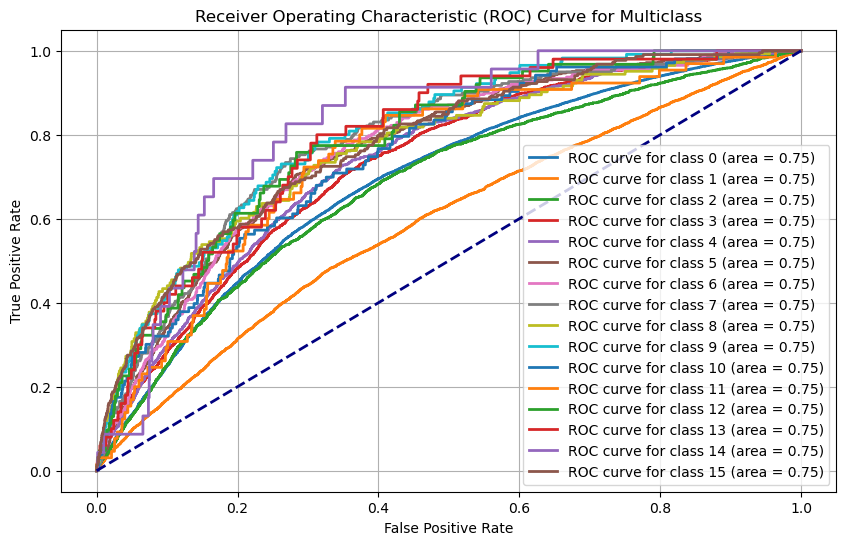

In [16]:
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

This plot represents the Receiver Operating Characteristic (ROC) curve for a multiclass classification problem. The ROC curve shows the trade-off between the True Positive Rate (TPR) (sensitivity or recall) and the False Positive Rate (FPR) for each class.

Key elements of the graph:

- Multiple Curves: Each line represents the ROC curve for a different class (total of 16 classes). The True Positive Rate is plotted against the False Positive Rate at various classification thresholds, providing insight into the model's performance for each individual class.
- AUC Value: The Area Under the Curve (AUC) is provided for each class, which measures the model's ability to distinguish between positive and negative cases. The AUC values are consistently 0.75 for all classes, suggesting that the model performs similarly across all classes, but the performance is moderate (an AUC of 1 would indicate perfect classification).
- Diagonal Line: The dashed diagonal line represents the baseline performance, which is equivalent to random guessing. A good model's ROC curve should be above this line. In this plot, most of the curves are above the baseline, indicating that the model is doing better than random guessing but still not optimal.

Observations:

- Moderate Performance: The AUC of 0.75 for each class suggests that the model has moderate discriminative power for each of the 16 classes. It indicates that the model can differentiate between positive and negative classes 75% of the time on average.
- Overlap Between Curves: The overlapping nature of the curves indicates that the model's discriminative power is relatively consistent across all classes. However, the model might not be adequately capturing the differences between some classes, as evidenced by the close proximity of the curves.
- Class Imbalance: The similar AUC values for all classes suggest that there might be an issue of class imbalance, where certain classes dominate the training data. This could lead to the model treating the classes similarly.

In summary, this ROC plot suggests that the model performs moderately well in distinguishing between the different classes, but the performance is not exceptional, possibly indicating a need for further tuning or dealing with class imbalance. Additional improvements could involve more sophisticated hyperparameter tuning, feature engineering, or using strategies to address class imbalance, such as oversampling or class weighting.

**Precision-Recall Curve for the Best Model**

This curve helps us understand the model's performance in terms of precision and recall across various thresholds. It is particularly useful when the dataset is imbalanced, as it focuses on the positive (minority) class.

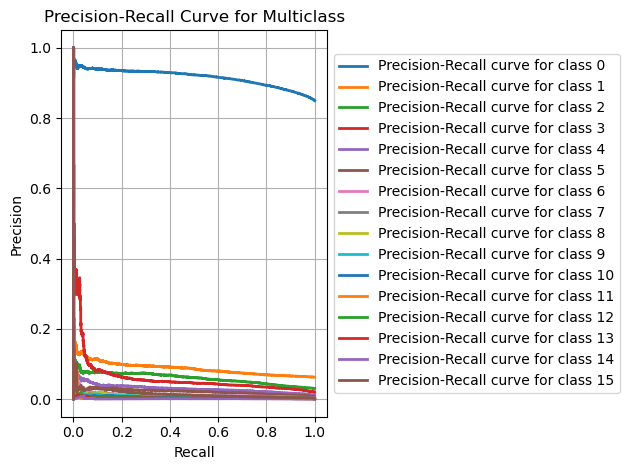

In [19]:
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Compute precision-recall curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve for class {i}')

# Plotting the precision-recall curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  # Move legend outside of the plot
plt.grid()
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


The Precision-Recall curve shown above visualizes the trade-off between precision and recall for each class in a multiclass classification problem. Here's what the chart represents:

- Precision is the ratio of true positive predictions to the total positive predictions made by the model, indicating how precise the classifier is when predicting a particular class.
- Recall (also called sensitivity or true positive rate) is the ratio of true positives to the actual positives, indicating how well the classifier captures all instances of a class.
For this multiclass scenario, each line represents the precision-recall curve for a different class, showing the relationship between these metrics across different thresholds.

Observations:

- Class Imbalance: The variability in the curves suggests that the dataset likely has an imbalance between classes, where some classes may be more represented than others. The blue line (representing class 0) stands out, while others tend to cluster closer to the lower left corner, indicating lower recall and precision.
- Performance Variation: For most classes, precision drops off quickly, while recall increases, suggesting the model struggles to consistently predict correctly as more positive cases are identified.
- Low Recall for Many Classes: Many curves are clustered near the axes, indicating that the model has difficulty correctly identifying true positives for most classes, which results in lower recall values.

The precision-recall curve is particularly useful for evaluating models with imbalanced datasets, as ROC curves can be misleading when dealing with such cases. In this plot, the fact that most of the curves are clustered low suggests that further tuning or changes (e.g., handling class imbalance) might improve the model's performance for certain classes.

**Error Bars for ROC-AUC and Precision Scores**

The subplots display the mean values of ROC-AUC and Precision scores for the best model, along with error bars representing the 95% confidence intervals calculated using the results from nested cross-validation. This visualization is helpful for understanding the variability in the model's performance and assessing how stable the metrics are across different folds of cross-validation. The smaller the error bars, the more reliable the performance metric is, indicating less variability and greater confidence in the model's performance.

This approach helps highlight areas where the model is either consistent or shows high variance, giving insights into the overall stability and reliability of the chosen model.

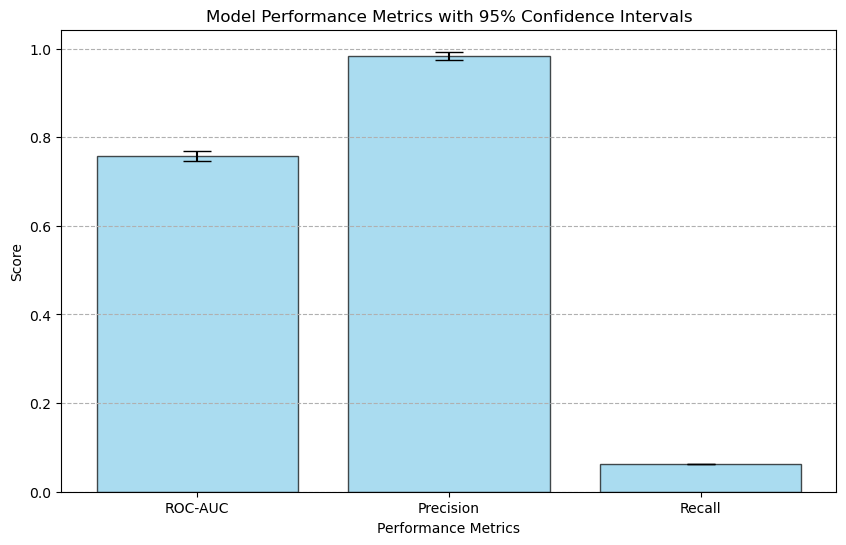

In [30]:
roc_auc_scores = results_df['roc_auc']
precision_scores = results_df['precision']
recall_scores = results_df['recall']

# Calculate mean, standard error, and confidence interval
def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = sem(data)
    h = se * t.ppf((1 + confidence) / 2., n - 1)
    return mean, se, h

# Metrics and confidence intervals
metrics = {
    'ROC-AUC': calculate_confidence_interval(roc_auc_scores),
    'Precision': calculate_confidence_interval(precision_scores),
    'Recall': calculate_confidence_interval(recall_scores)
}

# Visuals
metrics_names = list(metrics.keys())
means = [metrics[name][0] for name in metrics_names]
errors = [metrics[name][2] for name in metrics_names]

# Error bars for metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, means, yerr=errors, capsize=10, color='skyblue', alpha=0.7, edgecolor='black')
plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Model Performance Metrics with 95% Confidence Intervals')
plt.grid(axis='y', linestyle='--')
plt.show()

This plot displays the ROC-AUC, Precision, and Recall scores of the best model, along with their respective 95% confidence intervals. The error bars represent the confidence interval, providing insight into the stability of each performance metric across different cross-validation folds. The high precision, coupled with relatively lower recall, suggests that the model is highly specific in predicting positive cases but may miss some instances, which is indicative of an imbalanced dataset. The confidence intervals help understand the reliability of these metrics in assessing the model’s robustness.

**Feature Importances for XGBoost Model**

This plot illustrates the top 15 features based on their importance scores as determined by the XGBoost model. Feature importance measures the contribution of each feature to the predictive power of the model. 'Sex' and 'ClaimsTruncated' have the highest scores, suggesting they play crucial roles in the model's decision-making process. By examining feature importance, we gain valuable insights into which attributes are most impactful, thereby enabling better interpretation of the model's predictions and potentially guiding future feature engineering efforts to improve model performance.

C:\Users\brian\AppData\Local\Temp\ipykernel_19312\981592872.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


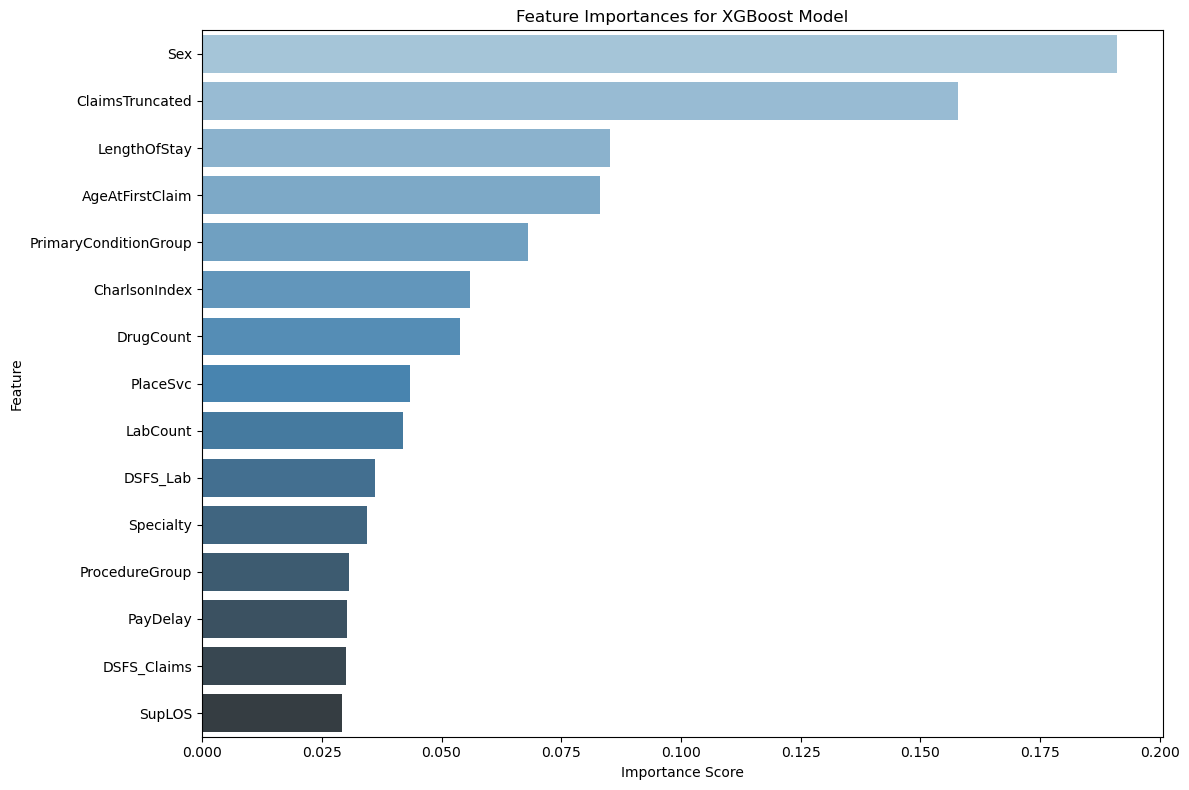

In [35]:
best_model.fit(X_train, y_train)

# Extract feature importances from the fitted XGBoost model
feature_importances = best_model.feature_importances_
features = X_train.columns

# Visuals
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost Model')
plt.tight_layout()
plt.show()

This bar chart displays the top 15 most important features for the XGBoost model. The feature importance scores reflect the contribution of each feature to the model's predictions. Features such as 'Sex' and 'ClaimsTruncated' are shown to be highly influential, indicating they played a significant role in determining the model's output. The importance score is derived based on how frequently a feature was used in making key decisions within the trees of the model. By analyzing the relative importance of features, we can gain insights into which aspects of the data have the most predictive power in determining the target outcome.